In [1]:
import pandas as pd
import json
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

### Leitura do arquivo

No Firebase os dados encontram-se ordenados como estruturas aninhadas. Vamos usar a função Export JSON no Firebase console.

<img src=firebase_object_tree.png width=200>


A função *Exportar o JSON* fica à direita na visão de base de dados:
<img src=export_json.png width=500>

In [2]:
arquivo = open("teste-ab-export.json")
linhas = arquivo.readlines()
texto = "".join(linhas)
dados_fire = json.loads(texto)

### Análise do atributo logs

 Veja que log, que contém todos os dados, está pesadamente aninhado

In [3]:
for k,v in dados_fire["logs"].items():
    # print(k,v) # habilite para imprimir as chaves de mais alto nível
    for chave, valor in v.items():
        # print(chave, valor) # habilite para imprimir as chaves inferiores
        pass # desabilite quando reabilitar a linha de cima



### Convertendo para um dataframe

O pandas entende listas de dicionários que têm as mesmas chaves. O Firebase nos dá dicionários de dicionários de dicionários. 

Vamos precisar converter. Basta inserir todos os itens que estavam na chave "logs" em uma lista

In [4]:
lista_dicionarios = []

for k,v in dados_fire["logs"].items():
    lista_dicionarios.append(v)

        


A função `from_records` converte a lista de dicionários em um dataframe

In [5]:
dataframe = pd.DataFrame.from_records(lista_dicionarios)

Desta forma temos o dataframe. Observe que os eventos são dos seguintes tipos:

* *inicio* - quando um usuário inicia uma tarefa
* final - quando o usuário termina uma tarefa

Precisamos agrupar pelo `id` do usuário e depois subtrair o tempo inicial do final, para sabermos quanto tempo efetivamente levou aquela tarefa

In [6]:
dataframe

,tempo,tipo,user_id,versao
0,1477664068029,final,1553786348,B
1,1477663929091,final,2651814347,A
2,1477664456181,inicio,2343346768,A
3,1477663909716,inicio,2044963915,B
4,1477664378592,inicio,1444491092,B
5,1477663930085,final,2044963915,B
6,1477664083512,final,1355150594,B
7,1477664711746,final,1749219710,B
8,1477663828879,inicio,1257728698,B
9,1477663858740,final,1165998542,A


### Convertendo para um DataFrame de delta_t

In [7]:
agrupado = dataframe.groupby(by=["user_id", "versao"])

In [8]:
users = set(dataframe.user_id) # We convert it to a set so that each user appear only once

In [9]:
users = list(users) 

In [10]:
resultados = []

for u in users:
    for versao in ["A", "B"]:
        if (u, versao) in agrupado.groups.keys(): # Check if a specific pair user/type of test happened
            grupo1 =  agrupado.get_group((u, versao))
            grupo1 = grupo1.sort_values(by="tempo") # Para evitar que inícios sem fim gerem tempos negativos
            
            if len(grupo1[grupo1.tipo=="final"])>= 1 and len(grupo1[grupo1.tipo=="inicio"]) >= 1:
                delta_t = grupo1[grupo1.tipo=="final"].iloc[-1].tempo - grupo1[grupo1.tipo=="inicio"].iloc[0].tempo
                resultados.append({"user_id":u, "delta_t":delta_t, "versao":versao})

In [11]:
grupo1.sort_values(by="tempo")

,tempo,tipo,user_id,versao
41,1477664695457,inicio,1749219710,B
7,1477664711746,final,1749219710,B


In [12]:
dataframe_resumo = pd.DataFrame.from_records(resultados)

In [13]:
dataframe_resumo.delta_t/=1000 # Convertendo milissegundos em segundos

In [14]:
dataframe_resumo

,delta_t,user_id,versao
0,103.482,1355150594,B
1,101.038,1561760900,B
2,106.965,1556610181,B
3,35.683,3292763014,A
4,46.894,3292763014,B
5,19.843,45210118,A
6,30.681,2286733576,B
7,19.265,3705282954,A
8,74.751,3705282954,B
9,32.768,947912844,A


# Comparação dos histogramas

(array([ 19.,   4.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,   1.]),
 array([  16.289 ,   71.3663,  126.4436,  181.5209,  236.5982,  291.6755,
         346.7528,  401.8301,  456.9074,  511.9847,  567.062 ]),
 <a list of 10 Patch objects>)

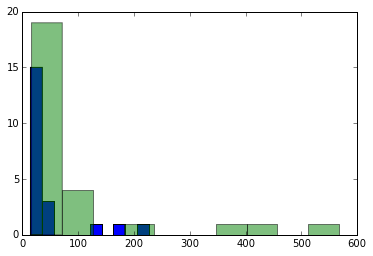

In [21]:
tempos_A = list(dataframe_resumo[dataframe_resumo.versao=="A"].delta_t)
tempos_B = list(dataframe_resumo[dataframe_resumo.versao=="B"].delta_t)
plt.hist(tempos_A, bins=10)
plt.hist(tempos_B, bins=10, alpha=0.5)